In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_excel('hackathon.xlsx')

df["TIME_STAMP"] = pd.to_datetime(df["TIME_STAMP"])

df = df.sort_values(by="TIME_STAMP")

df.head(5)

,TIME_STAMP,SERVER_NAME,DOWNLOAD,UPLOAD
35428,2023-11-02 10:10:00,10.0.901.xx Server 1,14611.335,357.395
35427,2023-11-02 10:15:00,10.0.901.xx Server 1,14336.298,355.811
35426,2023-11-02 10:20:00,10.0.901.xx Server 1,14381.373,357.816
35425,2023-11-02 10:25:00,10.0.901.xx Server 1,14461.797,358.717
35424,2023-11-02 10:30:00,10.0.901.xx Server 1,14604.990,364.365


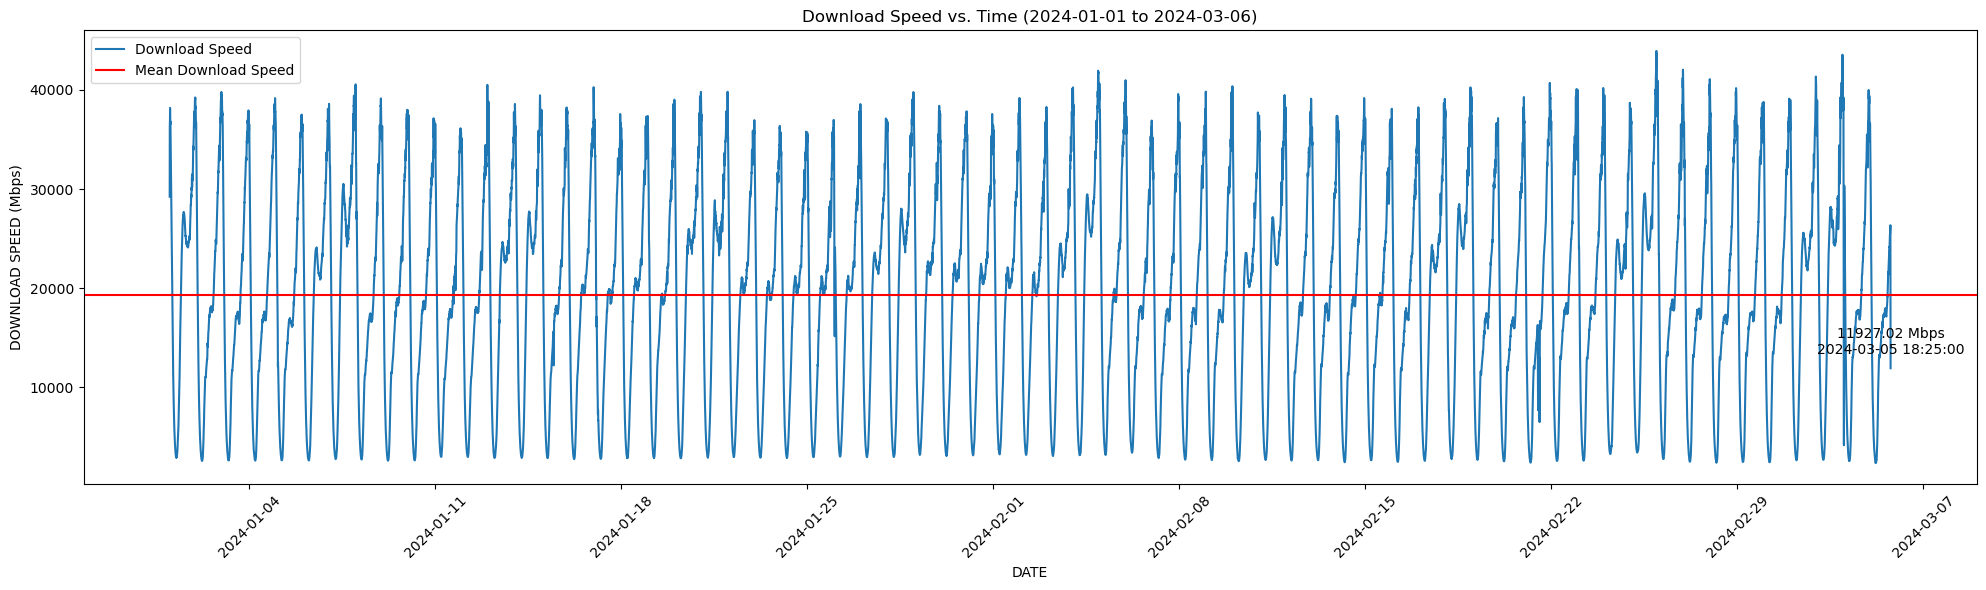

Tam olarak 2024-03-05 18:25:00 zamanında veri var mı: True


In [3]:
start_date = pd.Timestamp('2024-01-01')
end_date = pd.Timestamp('2024-03-06')

df_filtered = df[(df['TIME_STAMP'] >= start_date) & (df['TIME_STAMP'] <= end_date)]


plt.figure(figsize=(20, 6))  # Grafiği daha geniş ve kısa yapalım
plt.plot(df_filtered['TIME_STAMP'], df_filtered['DOWNLOAD'], label='Download Speed')
plt.axhline(y=df_filtered['DOWNLOAD'].mean(), color='r', linestyle='-', label='Mean Download Speed')

specific_point = pd.Timestamp('2024-03-05 18:25:00')

nearest_idx = np.argmin(np.abs(df_filtered['TIME_STAMP'] - specific_point))
nearest_point = df_filtered.iloc[nearest_idx]


plt.annotate(f"{nearest_point['DOWNLOAD']:.2f} Mbps\n{nearest_point['TIME_STAMP']}",
             (nearest_point['TIME_STAMP'], nearest_point['DOWNLOAD']),
             textcoords="offset points", xytext=(0,10), ha='center')

plt.xlabel('DATE')
plt.ylabel('DOWNLOAD SPEED (Mbps)')
plt.legend()
plt.title(f'Download Speed vs. Time ({start_date.date()} to {end_date.date()})')

plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.DayLocator(interval=7))  # Her 7 günde bir işaret

plt.xticks(rotation=45)
plt.tight_layout()  
plt.show()

print(f"Tam olarak {specific_point} zamanında veri var mı: {specific_point in df_filtered['TIME_STAMP'].values}")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35429 entries, 35428 to 0
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   TIME_STAMP   35429 non-null  datetime64[ns]
 1   SERVER_NAME  35429 non-null  object        
 2   DOWNLOAD     35427 non-null  float64       
 3   UPLOAD       35427 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 1.4+ MB


In [5]:
eksik_degerler = df.isna().sum()
print(eksik_degerler)
df.describe()

TIME_STAMP     0
SERVER_NAME    0
DOWNLOAD       2
UPLOAD         2
dtype: int64


,TIME_STAMP,DOWNLOAD,UPLOAD
count,35429,35427.000000,35427.000000
mean,2024-01-03 13:59:16.925117696,19052.251090,482.140941
min,2023-11-02 10:10:00,2335.885000,57.749000
25%,2023-12-03 12:05:00,11342.646000,264.406500
50%,2024-01-03 13:55:00,18816.920000,475.543000
75%,2024-02-03 15:45:00,26627.177000,668.998000
max,2024-03-05 18:25:00,43930.614000,1670.995000
std,NaN,10213.032412,267.930799


In [6]:
df['DOWNLOAD'].ffill(inplace=True)
df['UPLOAD'].ffill(inplace=True)

In [7]:
from sklearn.preprocessing import LabelEncoder,StandardScaler

le = LabelEncoder()
df['SERVER_NAME'] = le.fit_transform(df['SERVER_NAME'])

In [8]:

df['WEEKDAY'] = df['TIME_STAMP'].dt.dayofweek
df['HOUR'] = df['TIME_STAMP'].dt.hour
df['MINUTE'] = df['TIME_STAMP'].dt.minute

In [9]:
bayram_gunleri = ['2023-04-20', '2023-04-21', '2023-04-22' ,'2023-04-23','2023-04-22','2023-06-28',
                  '2023-06-29','2023-06-30','2023-07-01','2024-03-10', '2024-03-11', '2024-03-12']  # Örnek tarihler
df['HOLIDAY'] = df['TIME_STAMP'].dt.strftime('%Y-%m-%d').isin(bayram_gunleri).astype(int)

In [10]:
features = ['HOUR', 'MINUTE', 'DOWNLOAD', 'UPLOAD'] + [col for col in df.columns if col.startswith('SERVER_NAME_')]

In [11]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[features])

In [12]:
model = IsolationForest(contamination=0.01, random_state=42)
df['ANOMALY'] = model.fit_predict(df_scaled)


In [13]:
check_point = pd.to_datetime('2024-03-05 18:25:00')
server_name = '10.0.901.xx Server 1'
download = 11927.017
upload = 424.7

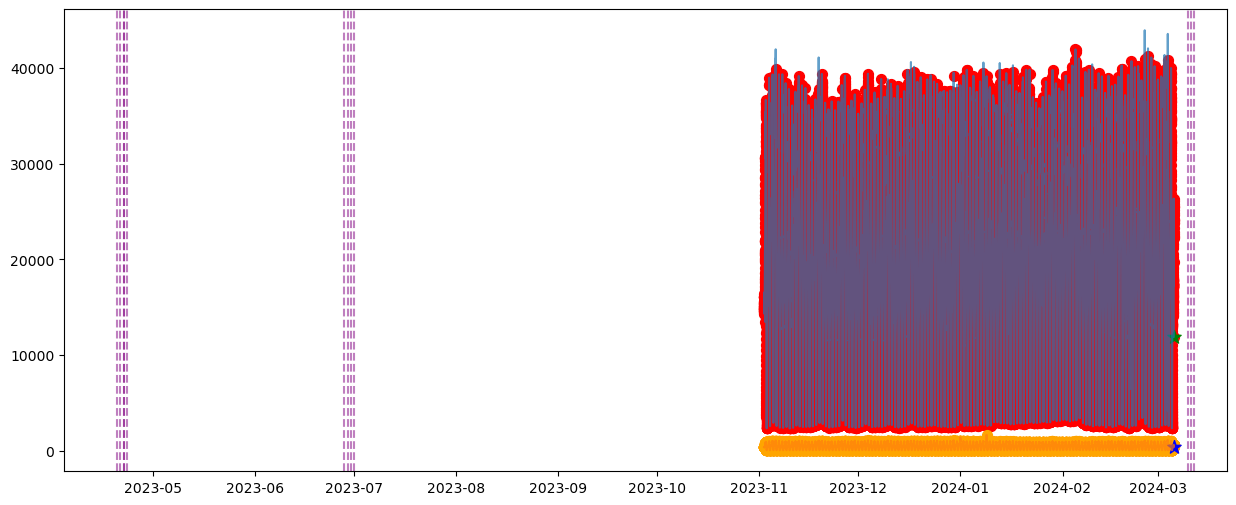

In [14]:
plt.figure(figsize=(15, 6))
plt.plot(df['TIME_STAMP'], df['DOWNLOAD'], label='Download', alpha=0.7)
plt.plot(df['TIME_STAMP'], df['UPLOAD'], label='Upload', alpha=0.7)
anomalies = df[df['ANOMALY'] == 1]
plt.scatter(anomalies['TIME_STAMP'], anomalies['DOWNLOAD'], color='red', label='Anomalies (Download)', s=50)
plt.scatter(anomalies['TIME_STAMP'], anomalies['UPLOAD'], color='orange', label='Anomalies (Upload)', s=50)

plt.scatter(check_point, download, color='green', s=100, marker='*', label='Check Point (Download)')
plt.scatter(check_point, upload, color='blue', s=100, marker='*', label='Check Point (Upload)')

for holiday in bayram_gunleri:
    holiday_date = pd.to_datetime(holiday)
    plt.axvline(x=holiday_date, color='purple', linestyle='--', alpha=0.5)

In [15]:

check_features = pd.DataFrame({
    'TIME_STAMP': [check_point],
    #'WEEKDAY': [check_point.dayofweek],
    'HOUR': [check_point.hour],
    'MINUTE': [check_point.minute],
    'DOWNLOAD': [download],
    'UPLOAD': [upload],
})

In [16]:
for col in df.columns:
    if col.startswith('SERVER_NAME_'):
        check_features[col] = [1 if col == f'SERVER_NAME_{server_name}' else 0]


In [17]:
check_scaled = scaler.transform(check_features[features])

anomaly_prediction = model.predict(check_scaled)

In [18]:
if anomaly_prediction[0] == 1:
    print("Verilen veri noktası bir anomali olarak tespit edilmiştir.")
else:
    print("Verilen veri noktası normal olarak değerlendirilmiştir.")

anomaly_score = model.score_samples(check_scaled)
print(f"Anomali skoru: {anomaly_score[0]:.4f}")

Verilen veri noktası bir anomali olarak tespit edilmiştir.
Anomali skoru: -0.5422
